## **Advanced Features - Phase 1 (Trade-Level & Time-Series)**

**Purpose:** Compute sophisticated microstructure features from trades and aggregates

**What it does:**

- Enhances basic features with advanced metrics
- Computes microstructure noise estimates
- Analyzes price impact and execution costs
- Extracts volatility signatures and trade clustering patterns
- Creates rolling higher-order moments

**Prerequisites:**

- Completed `10_basic_features.ipynb` ✓
- Phase 1 features saved to `data/processed/AAPL_features_phase1.parquet`

**Advanced Features (Phase 1 - No LOB Required):**

1. **Microstructure Noise:** Roll estimator, effective spread proxies
2. **Price Impact:** Trade-weighted price changes, execution cost proxies
3. **Volatility Signatures:** Time-scale dependent volatility patterns
4. **Trade Clustering:** Burst detection, arrival process analysis
5. **Higher-Order Moments:** Skewness, kurtosis of returns and volumes
6. **Autocorrelation Features:** Return autocorrelation, volume persistence

**Note:** Book shape features (volume decay, depth imbalance) deferred to Phase 3 (requires L2 data)


In [1]:
# ============================================================================
# 15_advanced_features.ipynb
# Purpose: Compute advanced microstructure features (Phase 1: trades + aggregates)
# ============================================================================

# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats
import json

# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline

from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR

In [2]:
# %% Configuration
TICKER = "AAPL"
DATE = "2024-12-09"

print(f"Ticker: {TICKER}")
print(f"Date: {DATE}")
print(f"\nBuilding on Phase 1 basic features")

Ticker: AAPL
Date: 2024-12-09

Building on Phase 1 basic features


## Load Data


In [ ]:
# %% Load basic features and raw data
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Load Phase 1 features
features_file = PROCESSED_DATA_DIR / f"{TICKER}_features_phase1.parquet"
print(f"\nLoading Phase 1 features: {features_file}")
features_df = pd.read_parquet(features_file)
print(f"  Loaded {len(features_df):,} rows, {features_df.shape[1]} features")

# Load raw trades for advanced analysis
trades_file = INTERIM_DATA_DIR / f"{TICKER}_trades_cleaned.parquet"
print(f"\nLoading cleaned trades: {trades_file}")
trades_df = pd.read_parquet(trades_file)
trades_df["timestamp"] = pd.to_datetime(trades_df["timestamp"], utc=True)
trades_df = trades_df.sort_values("timestamp").reset_index(drop=True)
print(f"  Loaded {len(trades_df):,} trades")

# Load aggregates
agg_file = INTERIM_DATA_DIR / f"{TICKER}_aggregates_cleaned.parquet"
print(f"\nLoading aggregates: {agg_file}")
aggregates_df = pd.read_parquet(agg_file)
aggregates_df["timestamp"] = pd.to_datetime(aggregates_df["timestamp"], utc=True)
aggregates_df = aggregates_df.set_index("timestamp").sort_index()
print(f"  Loaded {len(aggregates_df):,} minute bars")

LOADING DATA

Loading Phase 1 features: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/AAPL_features_phase1.parquet
  Loaded 575 rows, 46 features

Loading cleaned trades: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_trades_cleaned.parquet
  Loaded 4,441 trades

Loading aggregates: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_aggregates_cleaned.parquet
  Loaded 726 minute bars


## 1. Microstructure Noise Features

Measure noise and inefficiency in price formation


In [ ]:
# %% Roll estimator of bid-ask spread
print("\n" + "=" * 60)
print("MICROSTRUCTURE NOISE - ROLL ESTIMATOR")
print("=" * 60)

# Compute returns
aggregates_df["returns"] = aggregates_df["close"].pct_change()

# Roll (1984) estimator: spread ≈ 2 * sqrt(-cov(r_t, r_{t-1}))
# Based on bid-ask bounce causing negative autocorrelation
window = 30  # 30-minute rolling window


def roll_spread(returns, window):
    """Estimate effective spread using Roll (1984) method."""
    roll_cov = returns.rolling(window=window).apply(
        lambda x: np.cov(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan
    )
    # Only valid when covariance is negative
    spread = 2 * np.sqrt(-roll_cov.clip(upper=0))
    return spread


aggregates_df["roll_spread"] = roll_spread(aggregates_df["returns"], window)

# Replace inf/nan with 0
aggregates_df["roll_spread"] = (
    aggregates_df["roll_spread"].replace([np.inf, -np.inf], np.nan).fillna(0)
)

print(f"\nRoll Spread Estimates:")
print(f"  Mean: {aggregates_df['roll_spread'].mean():.6f}")
print(f"  Median: {aggregates_df['roll_spread'].median():.6f}")
print(f"  Interpretation: Higher values suggest more bid-ask bounce (noise)")


MICROSTRUCTURE NOISE - ROLL ESTIMATOR

Roll Spread Estimates:
  Mean: 0.000229
  Median: 0.000163
  Interpretation: Higher values suggest more bid-ask bounce (noise)


In [ ]:
# %% Effective spread proxy from high-frequency variance
print("\n" + "=" * 60)
print("EFFECTIVE SPREAD FROM VARIANCE RATIO")
print("=" * 60)

# Variance ratio test: ratio of multi-period to single-period variance
# Under efficient markets, should be linear in horizon
# Deviation indicates microstructure noise


def variance_ratio(returns, lag=5):
    """Compute variance ratio for noise detection."""
    var_1 = returns.rolling(window=30).var()
    var_k = returns.rolling(window=30).apply(
        lambda x: (x.rolling(lag).sum()).var() if len(x) >= lag else np.nan
    )
    vr = var_k / (lag * var_1)
    return vr


aggregates_df["variance_ratio_5"] = variance_ratio(aggregates_df["returns"], lag=5)
aggregates_df["variance_ratio_5"] = (
    aggregates_df["variance_ratio_5"].replace([np.inf, -np.inf], np.nan).fillna(1)
)

print(f"\nVariance Ratio (5-minute):")
print(f"  Mean: {aggregates_df['variance_ratio_5'].mean():.3f}")
print(f"  Std: {aggregates_df['variance_ratio_5'].std():.3f}")
print(f"  < 1: Negative autocorrelation (bid-ask bounce)")
print(f"  > 1: Positive autocorrelation (momentum)")


EFFECTIVE SPREAD FROM VARIANCE RATIO

Variance Ratio (5-minute):
  Mean: 0.672
  Std: 0.346
  < 1: Negative autocorrelation (bid-ask bounce)
  > 1: Positive autocorrelation (momentum)


## 2. Price Impact Features

Analyze execution costs and market impact from trades


In [ ]:
# %% Price impact estimation
print("\n" + "=" * 60)
print("PRICE IMPACT ANALYSIS")
print("=" * 60)

# Merge trades with mid-price from aggregates
trades_with_mid = pd.merge_asof(
    trades_df.sort_values("timestamp"),
    aggregates_df[["mid_price"]].reset_index().sort_values("timestamp"),
    on="timestamp",
    direction="backward",
)

# Temporary price impact: deviation from mid-price
trades_with_mid["temp_impact"] = (
    trades_with_mid["price"] - trades_with_mid["mid_price"]
) / trades_with_mid["mid_price"]

# Forward price change (5 trades ahead)
trades_with_mid["forward_price_5"] = trades_with_mid["price"].shift(-5)
trades_with_mid["permanent_impact_5"] = (
    trades_with_mid["forward_price_5"] - trades_with_mid["price"]
) / trades_with_mid["price"]

# Size-adjusted impact (larger trades should have more impact)
trades_with_mid["impact_per_share"] = trades_with_mid["temp_impact"] / np.log1p(
    trades_with_mid["size"]
)

# Aggregate to 1-minute
trades_indexed = trades_with_mid.set_index("timestamp")
impact_features = (
    trades_indexed.resample("1min")
    .agg(
        {
            "temp_impact": ["mean", "std"],
            "permanent_impact_5": "mean",
            "impact_per_share": "mean",
        }
    )
    .fillna(0)
)

impact_features.columns = [
    "_".join(col).strip() for col in impact_features.columns.values
]
impact_features = impact_features.add_prefix("impact_")

print(f"\nPrice Impact Statistics:")
print(f"  Mean temporary impact: {trades_with_mid['temp_impact'].mean():.6f}")
print(
    f"  Mean permanent impact (5-trade): {trades_with_mid['permanent_impact_5'].mean():.6f}"
)
print(f"  Impact per share: {trades_with_mid['impact_per_share'].mean():.6f}")


PRICE IMPACT ANALYSIS

Price Impact Statistics:
  Mean temporary impact: -0.000058
  Mean permanent impact (5-trade): 0.000016
  Impact per share: -0.000011


## 3. Volatility Signature Analysis

Study time-scale dependent volatility patterns


In [ ]:
# %% Volatility signature (time-scale analysis)
print("\n" + "=" * 60)
print("VOLATILITY SIGNATURE")
print("=" * 60)

# Compute realized volatility at multiple time scales
for scale in [1, 5, 10, 15, 30]:
    # Realized variance over window
    rv = aggregates_df["returns"].rolling(window=scale).apply(lambda x: np.sum(x**2))
    aggregates_df[f"rv_scale_{scale}min"] = np.sqrt(rv)

# Volatility signature plot should show U-shape if microstructure noise present
# (high at very short scales due to noise, decreases, then increases with fundamental vol)

print(f"\nRealized Volatility by Time Scale:")
for scale in [1, 5, 10, 15, 30]:
    col = f"rv_scale_{scale}min"
    print(f"  {scale:2d}-min: {aggregates_df[col].mean():.6f}")


VOLATILITY SIGNATURE

Realized Volatility by Time Scale:
   1-min: 0.000305
   5-min: 0.000827
  10-min: 0.001223
  15-min: 0.001534
  30-min: 0.002273


In [ ]:
# %% Volatility clustering (GARCH-like features)
print("\n" + "=" * 60)
print("VOLATILITY CLUSTERING")
print("=" * 60)

# EWMA volatility (like GARCH)
aggregates_df["vol_ewma_fast"] = aggregates_df["returns"].ewm(span=5).std()
aggregates_df["vol_ewma_slow"] = aggregates_df["returns"].ewm(span=30).std()

# Volatility regime (fast > slow indicates high volatility regime)
aggregates_df["vol_regime"] = (
    (aggregates_df["vol_ewma_fast"] / aggregates_df["vol_ewma_slow"])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(1)
)

print(f"\nVolatility Clustering Metrics:")
print(f"  Fast EWMA vol: {aggregates_df['vol_ewma_fast'].mean():.6f}")
print(f"  Slow EWMA vol: {aggregates_df['vol_ewma_slow'].mean():.6f}")
print(f"  Vol regime ratio: {aggregates_df['vol_regime'].mean():.3f}")
print(f"  High vol periods (ratio > 1.5): {(aggregates_df['vol_regime'] > 1.5).sum()}")


VOLATILITY CLUSTERING

Volatility Clustering Metrics:
  Fast EWMA vol: 0.000381
  Slow EWMA vol: 0.000421
  Vol regime ratio: 0.867
  High vol periods (ratio > 1.5): 26


## 4. Trade Clustering & Burst Detection

Identify periods of intense trading activity


In [ ]:
# %% Trade clustering metrics
print("\n" + "=" * 60)
print("TRADE CLUSTERING & BURSTS")
print("=" * 60)

# Compute inter-arrival times
trades_df["inter_arrival"] = trades_df["timestamp"].diff().dt.total_seconds()

# Burst detection: periods where inter-arrival < threshold
burst_threshold = 1.0  # 1 second
trades_df["in_burst"] = (trades_df["inter_arrival"] < burst_threshold).astype(int)

# Aggregate to minutes
trades_indexed = trades_df.set_index("timestamp")
cluster_features = (
    trades_indexed.resample("1min")
    .agg(
        {
            "in_burst": "sum",  # number of burst trades
            "inter_arrival": ["mean", "std", "min"],
        }
    )
    .fillna(0)
)

cluster_features.columns = [
    "_".join(col).strip() for col in cluster_features.columns.values
]
cluster_features = cluster_features.add_prefix("cluster_")

# Clustering intensity
cluster_features["cluster_intensity"] = cluster_features["cluster_in_burst_sum"] / (
    cluster_features["cluster_in_burst_sum"] + 1
)  # avoid div by zero

print(f"\nTrade Clustering Statistics:")
print(f"  Total burst trades: {trades_df['in_burst'].sum():,}")
print(f"  Burst percentage: {trades_df['in_burst'].mean()*100:.1f}%")
print(f"  Mean inter-arrival: {trades_df['inter_arrival'].mean():.2f} sec")


TRADE CLUSTERING & BURSTS

Trade Clustering Statistics:
  Total burst trades: 1,329
  Burst percentage: 29.9%
  Mean inter-arrival: 8.27 sec


## 5. Higher-Order Moments

Capture asymmetry and tail risk in price and volume distributions


In [ ]:
# %% Rolling skewness and kurtosis
print("\n" + "=" * 60)
print("HIGHER-ORDER MOMENTS")
print("=" * 60)

window = 30  # 30-minute rolling window

# Return skewness (asymmetry)
aggregates_df["return_skew"] = aggregates_df["returns"].rolling(window=window).skew()

# Return kurtosis (tail risk)
aggregates_df["return_kurt"] = aggregates_df["returns"].rolling(window=window).kurt()

# Volume skewness
aggregates_df["volume_skew"] = aggregates_df["volume"].rolling(window=window).skew()

# Volume kurtosis
aggregates_df["volume_kurt"] = aggregates_df["volume"].rolling(window=window).kurt()

# Replace inf/nan
for col in ["return_skew", "return_kurt", "volume_skew", "volume_kurt"]:
    aggregates_df[col] = aggregates_df[col].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\nHigher-Order Moments (30-min rolling):")
print(f"  Return skewness: {aggregates_df['return_skew'].mean():.3f}")
print(f"  Return kurtosis: {aggregates_df['return_kurt'].mean():.3f}")
print(f"  Volume skewness: {aggregates_df['volume_skew'].mean():.3f}")
print(f"  Volume kurtosis: {aggregates_df['volume_kurt'].mean():.3f}")
print(f"\nInterpretation:")
print(f"  Skewness > 0: Right-skewed (positive outliers)")
print(f"  Kurtosis > 3: Fat tails (extreme events)")


HIGHER-ORDER MOMENTS

Higher-Order Moments (30-min rolling):
  Return skewness: -0.151
  Return kurtosis: 2.022
  Volume skewness: 2.278
  Volume kurtosis: 8.229

Interpretation:
  Skewness > 0: Right-skewed (positive outliers)
  Kurtosis > 3: Fat tails (extreme events)


## 6. Autocorrelation Features

Measure persistence in returns and volumes


In [ ]:
# %% Autocorrelation features
print("\n" + "=" * 60)
print("AUTOCORRELATION ANALYSIS")
print("=" * 60)

# Return autocorrelation at multiple lags
for lag in [1, 5, 10]:
    aggregates_df[f"return_acf_{lag}"] = (
        aggregates_df["returns"]
        .rolling(window=30)
        .apply(lambda x: x.autocorr(lag=lag) if len(x) > lag else np.nan)
    )

# Volume autocorrelation
for lag in [1, 5, 10]:
    aggregates_df[f"volume_acf_{lag}"] = (
        aggregates_df["volume"]
        .rolling(window=30)
        .apply(lambda x: x.autocorr(lag=lag) if len(x) > lag else np.nan)
    )

# Replace inf/nan
acf_cols = [c for c in aggregates_df.columns if "_acf_" in c]
for col in acf_cols:
    aggregates_df[col] = aggregates_df[col].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\nReturn Autocorrelations:")
for lag in [1, 5, 10]:
    col = f"return_acf_{lag}"
    print(f"  Lag {lag:2d}: {aggregates_df[col].mean():.4f}")

print(f"\nVolume Autocorrelations:")
for lag in [1, 5, 10]:
    col = f"volume_acf_{lag}"
    print(f"  Lag {lag:2d}: {aggregates_df[col].mean():.4f}")


AUTOCORRELATION ANALYSIS

Return Autocorrelations:
  Lag  1: -0.1007
  Lag  5: -0.0190
  Lag 10: -0.0308

Volume Autocorrelations:
  Lag  1: 0.1512
  Lag  5: 0.0009
  Lag 10: -0.0170


## Merge Advanced Features with Basic Features


In [ ]:
# %% Merge all advanced features
print("\n" + "=" * 60)
print("MERGING ADVANCED FEATURES")
print("=" * 60)

# Select advanced features from aggregates
advanced_cols = [
    "roll_spread",
    "variance_ratio_5",
    "rv_scale_1min",
    "rv_scale_5min",
    "rv_scale_10min",
    "rv_scale_15min",
    "rv_scale_30min",
    "vol_ewma_fast",
    "vol_ewma_slow",
    "vol_regime",
    "return_skew",
    "return_kurt",
    "volume_skew",
    "volume_kurt",
    "return_acf_1",
    "return_acf_5",
    "return_acf_10",
    "volume_acf_1",
    "volume_acf_5",
    "volume_acf_10",
]

advanced_features = aggregates_df[advanced_cols].copy()
advanced_features = advanced_features.add_prefix("adv_")

# Merge with impact features
advanced_features = advanced_features.join(impact_features, how="left")

# Merge with clustering features
advanced_features = advanced_features.join(cluster_features, how="left")

# Fill NaN
advanced_features = advanced_features.fillna(0)

print(f"\nAdvanced features computed: {advanced_features.shape[1]} features")
print(
    f"Time coverage: {advanced_features.index.min()} to {advanced_features.index.max()}"
)
print(f"\nFeature categories:")
print(f"  Microstructure noise: 2")
print(
    f"  Price impact: {len([c for c in advanced_features.columns if 'impact_' in c])}"
)
print(f"  Volatility signature: 7")
print(f"  Higher-order moments: 4")
print(f"  Autocorrelation: 6")
print(
    f"  Trade clustering: {len([c for c in advanced_features.columns if 'cluster_' in c])}"
)


MERGING ADVANCED FEATURES

Advanced features computed: 29 features
Time coverage: 2024-12-09 09:00:00+00:00 to 2024-12-10 00:59:00+00:00

Feature categories:
  Microstructure noise: 2
  Price impact: 4
  Volatility signature: 7
  Higher-order moments: 4
  Autocorrelation: 6
  Trade clustering: 5


In [ ]:
# %% Merge with basic features
print("\n" + "=" * 60)
print("COMBINING WITH BASIC FEATURES")
print("=" * 60)

# Merge advanced features with basic features
combined_features = features_df.join(advanced_features, how="left")

# Fill any remaining NaN
combined_features = combined_features.fillna(0)

print(f"\nCombined feature set:")
print(f"  Shape: {combined_features.shape}")
print(f"  Basic features: {features_df.shape[1]}")
print(f"  Advanced features: {advanced_features.shape[1]}")
print(f"  Total features: {combined_features.shape[1]}")
print(f"  Missing values: {combined_features.isnull().sum().sum()}")


COMBINING WITH BASIC FEATURES

Combined feature set:
  Shape: (575, 75)
  Basic features: 46
  Advanced features: 29
  Total features: 75
  Missing values: 0


## Visualizations



VISUALIZATIONS


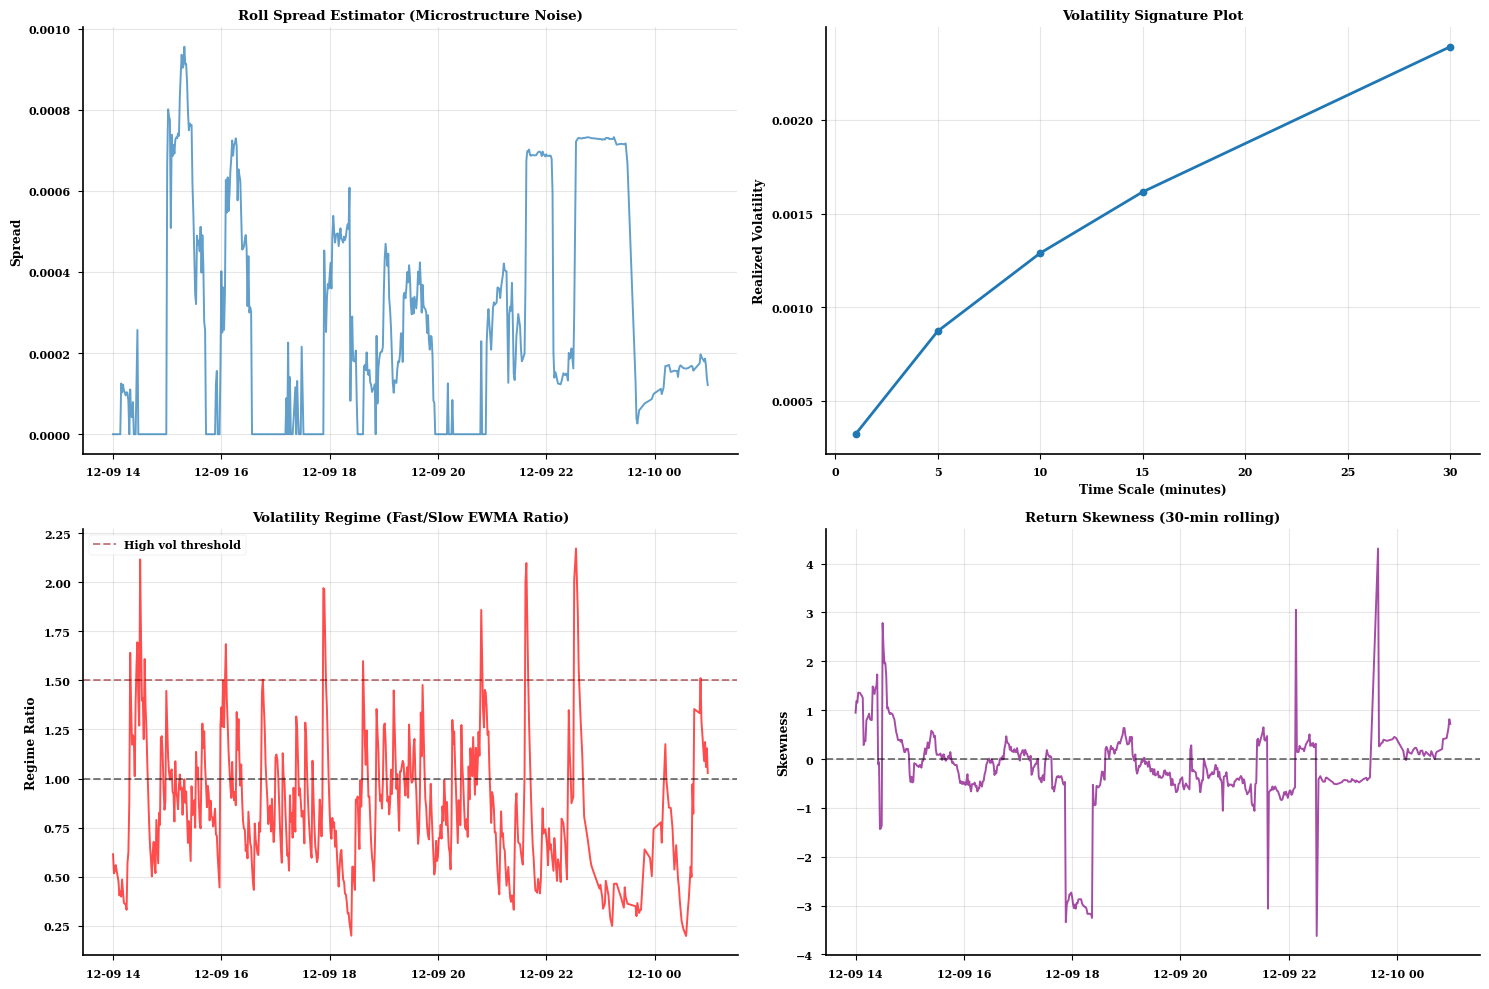


Saved: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_advanced_features.png


In [ ]:
# %% Visualization: Microstructure noise and volatility
print("\n" + "=" * 60)
print("VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Roll spread
axes[0, 0].plot(
    combined_features.index, combined_features["adv_roll_spread"], alpha=0.7
)
axes[0, 0].set_title("Roll Spread Estimator (Microstructure Noise)")
axes[0, 0].set_ylabel("Spread")
axes[0, 0].grid(True, alpha=0.3)

# Volatility signature
vol_sig_means = [
    combined_features[f"adv_rv_scale_{s}min"].mean() for s in [1, 5, 10, 15, 30]
]
axes[0, 1].plot([1, 5, 10, 15, 30], vol_sig_means, marker="o", linewidth=2)
axes[0, 1].set_title("Volatility Signature Plot")
axes[0, 1].set_xlabel("Time Scale (minutes)")
axes[0, 1].set_ylabel("Realized Volatility")
axes[0, 1].grid(True, alpha=0.3)

# Volatility regime
axes[1, 0].plot(
    combined_features.index, combined_features["adv_vol_regime"], alpha=0.7, color="red"
)
axes[1, 0].axhline(1, color="black", linestyle="--", alpha=0.5)
axes[1, 0].axhline(
    1.5, color="darkred", linestyle="--", alpha=0.5, label="High vol threshold"
)
axes[1, 0].set_title("Volatility Regime (Fast/Slow EWMA Ratio)")
axes[1, 0].set_ylabel("Regime Ratio")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Return skewness
axes[1, 1].plot(
    combined_features.index,
    combined_features["adv_return_skew"],
    alpha=0.7,
    color="purple",
)
axes[1, 1].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[1, 1].set_title("Return Skewness (30-min rolling)")
axes[1, 1].set_ylabel("Skewness")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / f"{TICKER}_advanced_features.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\nSaved: {FIGURES_DIR / f'{TICKER}_advanced_features.png'}")

## Save Combined Features


In [ ]:
# %% Save combined features
print("\n" + "=" * 60)
print("SAVING COMBINED FEATURES")
print("=" * 60)

# Save to processed directory
output_file = PROCESSED_DATA_DIR / f"{TICKER}_features_combined.parquet"
combined_features.to_parquet(output_file)
print(f"\n✓ Saved combined features to: {output_file}")
print(f"  Shape: {combined_features.shape}")
print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")

# Save metadata
metadata = {
    "created_at": datetime.now().isoformat(),
    "ticker": TICKER,
    "date": DATE,
    "data_source": "polygon.io",
    "phase": 1,
    "features": {
        "total_count": combined_features.shape[1],
        "basic_features": features_df.shape[1],
        "advanced_features": advanced_features.shape[1],
    },
    "data_shape": list(combined_features.shape),
    "time_coverage": {
        "start": str(combined_features.index.min()),
        "end": str(combined_features.index.max()),
        "duration_hours": (
            combined_features.index.max() - combined_features.index.min()
        ).total_seconds()
        / 3600,
    },
    "feature_list": combined_features.columns.tolist(),
    "notes": [
        "Combined basic (Phase 1) and advanced features",
        "Advanced features include microstructure noise, price impact, volatility signatures",
        "Book shape features deferred to Phase 3 (requires L2 data)",
    ],
}

metadata_file = PROCESSED_DATA_DIR / f"{TICKER}_features_combined_metadata.json"
with open(metadata_file, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Saved metadata to: {metadata_file}")


SAVING COMBINED FEATURES

✓ Saved combined features to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/AAPL_features_combined.parquet
  Shape: (575, 75)
  File size: 0.32 MB

✓ Saved metadata to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/AAPL_features_combined_metadata.json


## Summary


In [ ]:
# %% Summary
print("\n" + "=" * 60)
print("ADVANCED FEATURES COMPLETE")
print("=" * 60)

print(f"\n✓ Feature Summary:")
print(f"  Basic features (Phase 1): {features_df.shape[1]}")
print(f"  Advanced features: {advanced_features.shape[1]}")
print(f"  Total combined features: {combined_features.shape[1]}")

print(f"\n✓ Advanced Feature Categories:")
print(f"  Microstructure noise (Roll, variance ratio): 2")
print(
    f"  Price impact (temp, permanent, size-adjusted): {len([c for c in advanced_features.columns if 'impact_' in c])}"
)
print(f"  Volatility signatures (multi-scale): 7")
print(f"  Volatility clustering (EWMA, regime): 3")
print(f"  Higher-order moments (skew, kurtosis): 4")
print(f"  Autocorrelation (returns, volume): 6")
print(
    f"  Trade clustering (bursts, arrivals): {len([c for c in advanced_features.columns if 'cluster_' in c])}"
)

print(f"\n✓ Key Insights:")
print(f"  Mean Roll spread: {combined_features['adv_roll_spread'].mean():.6f}")
print(f"  Mean vol regime: {combined_features['adv_vol_regime'].mean():.3f}")
print(f"  Return skewness: {combined_features['adv_return_skew'].mean():.3f}")
print(f"  Return kurtosis: {combined_features['adv_return_kurt'].mean():.3f}")

print(f"\n→ Next Notebook: 25_dimensionality_reduction.ipynb")
print(f"   - Apply PCA to {combined_features.shape[1]} combined features")
print(f"   - Reduce to 10-15 principal components")
print(f"   - Retain 85-90% of variance")


ADVANCED FEATURES COMPLETE

✓ Feature Summary:
  Basic features (Phase 1): 46
  Advanced features: 29
  Total combined features: 75

✓ Advanced Feature Categories:
  Microstructure noise (Roll, variance ratio): 2
  Price impact (temp, permanent, size-adjusted): 4
  Volatility signatures (multi-scale): 7
  Volatility clustering (EWMA, regime): 3
  Higher-order moments (skew, kurtosis): 4
  Autocorrelation (returns, volume): 6
  Trade clustering (bursts, arrivals): 5

✓ Key Insights:
  Mean Roll spread: 0.000255
  Mean vol regime: 0.861
  Return skewness: -0.221
  Return kurtosis: 2.277

→ Next Notebook: 25_dimensionality_reduction.ipynb
   - Apply PCA to 75 combined features
   - Reduce to 10-15 principal components
   - Retain 85-90% of variance
